In [30]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tifffile
import yaml
from einops import rearrange

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

In [5]:

import mushroom.registration.bigwarp as bigwarp
import mushroom.utils as utils

In [6]:
project_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1'

In [18]:
default_scale = .2
dtype_to_scale = {}

## Define inputs

In [ ]:
def ddfs_from_data_map(data_map):
    target_sid = data_map['target_sid']

    sid_to_ddf = {}

    for idx, item in enumerate(data_map['sections']):
        sid = item['sid']
        mapping = item['data'][0]
        dtype, filepath = mapping['dtype'], mapping['filepath']
        scale = dtype_to_scale.get(dtype, default_scale)

        if sid != target_sid: # initial registration target section will not have ddf
            ddf_fp = os.path.join(reg_dir, f's{idx}_{sid}_ddf.tif')

            assert os.path.exists(ddf_fp), f'Expected a warp field file at {ddf_fp}, but no file was found.'
            ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, scale) # ddfs are (c h w)
            sid_to_ddf[sid] = ddf
    return sid_to_ddf

###### HT397B1

In [16]:
case = 'HT397B1'
output_dir = os.path.join(project_dir, case, 'auxiliary')
Path(output_dir).mkdir(parents=True, exist_ok=True)

['/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U12_spatial_features.txt',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U22_spatial_features.txt',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U2_spatial_features.txt',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U31_spatial_features.txt']

In [19]:
reg_dir = os.path.join(project_dir, case, 'registration')
data_map = yaml.safe_load(open(os.path.join(project_dir, case, 'registered', 'metadata.yaml')))

sid_to_ddf = ddfs_from_data_map(data_map)

sid_to_ddf.keys()

dict_keys(['HT397B1-U2', 'HT397B1-U12', 'HT397B1-U21', 'HT397B1-U22', 'HT397B1-U31'])

In [20]:
multiplex_fps = sorted(utils.listfiles(
    '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features',
    regex=r'features.txt$'
))
multiplex_fps

['/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U12_spatial_features.txt',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U22_spatial_features.txt',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U2_spatial_features.txt',
 '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U31_spatial_features.txt']

In [21]:
sid_to_multiplex = {
    'HT397B1-U2': '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U2_spatial_features.txt', 
    'HT397B1-U12': '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U12_spatial_features.txt',
    'HT397B1-U22': '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U22_spatial_features.txt',
    'HT397B1-U31': '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/mushroom/HT397B1/spatial_features/HT397B1-S1H3A1-U31_spatial_features.txt'
}

## common multiplex processing

In [53]:
sid_to_warped_df = {}
for sid, fp in sid_to_multiplex.items():
    print(sid)
    ddf = sid_to_ddf[sid]
    df = pd.read_csv(fp, sep='\t', index_col=0)
    pts = df[['row', 'col']].values.astype(int)
    warped, mask = bigwarp.warp_pts(pts, ddf)
    
    f = df[mask.numpy()]
    f['row'] = warped[:, 0]
    f['col'] = warped[:, 1]
    
    sid_to_warped_df[sid] = f

HT397B1-U2


/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['col'] = warped[:, 1]


HT397B1-U12


/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['col'] = warped[:, 1]


HT397B1-U22


/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['col'] = warped[:, 1]


HT397B1-U31


/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['row'] = warped[:, 0]
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_254830/4195257261.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f['col'] = warped[:, 1]


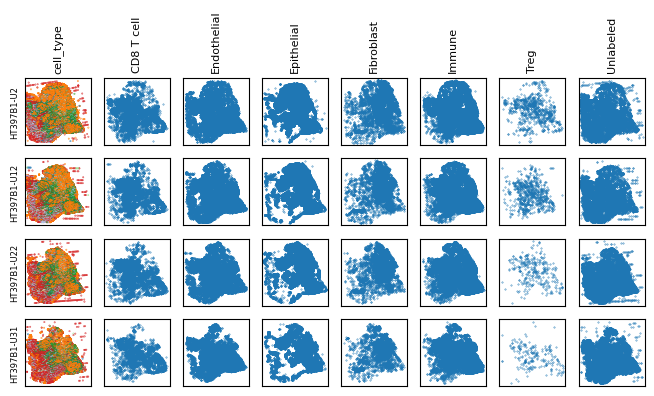

In [55]:
def format_axis(ax):
    ax.invert_yaxis()
    ax.axis('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.title.set_fontsize(8)
    ax.yaxis.label.set_fontsize(6)
    
cell_types = sorted(set([x for df in sid_to_warped_df.values() for x in df['cell_type']]))
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cell_type_to_color = {ct:c for ct, c in zip(cell_types, cmap)}

nrows, ncols = len(sid_to_warped_df), len(cell_types) + 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols, nrows))
max_x, max_y = 0, 0
for i, (sid, df) in enumerate(sid_to_warped_df.items()):
    ax = axs[i, 0]
    ax.scatter(df['col'], df['row'], c=[cell_type_to_color[x] for x in df['cell_type']], s=.1)
    ax.set_ylabel(sid, rotation=90)
    if i == 0:
        ax.set_title('cell_type', rotation=90)
    
    for j, ct in enumerate(cell_types):
        ax = axs[i, j + 1]
        f = df[df['cell_type']==ct]
        ax.scatter(f['col'], f['row'], s=.1)
        
        if i == 0:
            ax.set_title(ct, rotation=90)
    
    max_x = max(max_x, df['col'].max())
    max_y = max(max_y, df['row'].max())

for ax in axs.flatten():
    ax.set_xlim(0, max_x)
    ax.set_ylim(0, max_y)
    format_axis(ax)


In [56]:
save_dir = os.path.join(output_dir, 'multiplex')
Path(save_dir).mkdir(parents=True, exist_ok=True)
for sid, df in sid_to_warped_df.items():
    df.to_csv(os.path.join(save_dir, f'{sid}.txt'), sep='\t')

In [57]:
save_dir

'/diskmnt/Projects/Users/estorrs/mushroom/data/projects/submission_v1/HT397B1/auxiliary/multiplex'